#**Deep Learning Homework 3: Convolutional Neural Networks**
### MSc Computer Science, Data Science, Cybersecurity @UNIPD
### 2nd semester - 6 ECTS
### Prof. Alessandro Sperduti, Prof. Nicolò Navarin and Dr. Luca Pasa
---
In this homework, we will explore how to develop a simple Convolutional Neural Network for image classification. In the first part, we will learn how to develop a simple CNN, while in the second part we will explore the impact of various hyper-parameters on the learning performances.

# Requirements
Let's start importing the libraries we will need and setting a couple of environmental variables.

In [ ]:
!pip3 install skorch torchview torchinfo hiddenlayer portalocker

In [ ]:
import torch
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Linear
import torch.nn.functional as F
from torchvision.datasets import SVHN
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Lambda
import numpy as np
from torchview import draw_graph
from torchinfo import summary
import pandas as pd
import matplotlib.pyplot as plt
import hiddenlayer as hl
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore") #Conflict of nn.functional.act_f and torch.act_f

print("You are using:") # We tested with Python 3.10.12 and torch.__version__='2.2.1+cu121'
!python --version
print(f"{torch.__version__=}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")
!nvidia-smi --format=csv --query-gpu=index,name,driver_version,memory.total,memory.used,memory.free

# Set seed for reproducibility
torch.manual_seed(43)
rng = np.random.default_rng(seed=4242)

You are using:
Python 3.10.12
torch.__version__='2.2.1+cu121'
device=device(type='cuda')
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, Tesla T4, 535.104.05, 15360 MiB, 3 MiB, 15099 MiB


# Exercise 3.1: Simple CNN

## Q1: Data Loading and Preprocessing [TO COMPLETE]

We will use the  The Street View House Numbers `SVHN` dataset. This dataset comes from the real-world problem of recognizing digits and numbers in natural scene images (SVHN is obtained from house numbers in Google Street View). It consists of $10$ classes, 1 for each digit. Orignially, there are $73257$ digits for training and $26032$ digits for testing, but we will use a subset of those to speed up computations. Each sample is a $32\times32$ pixels color image (thus with an extra $\times3$ dimensions for the colors channels), associated with a label from one of the classes:

```python
classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
```

We will divide the dataset in training, testing and validation set. As you already know, the training set will be used to train the model, the validation set will be used to perform model selection and finally, the test set will be used to asses the performance of the network.

**[TO COMPLETE]**

In the standard dataset, each pixel intensity is represented by a `uint8` (byte) from $0$ to $255$. As a preprocessing step, we will rescale these values in the range $[0,1]$. You should write a simple so-called MinMaxScaler which takes as input a PIL Image (a specific format for images in Python) and rescales it, after making the appropriate type and shape transformations.

`%STARTCODE`

In [ ]:
def MinMaxScaler(img):#[TO COMPLETE]
  # First, we load the data as numpy array
  img_as_array = np.asarray(img)
  # TO COMPLETE: Transform the array to Tensor for PyTorch
  img_as_tensor = torch.tensor(img_as_array)

  # TO COMPLETE: image is of size (Height, Width, Channels). But torch excepts (C, H, W). Hence, the second thing is to permute.
  img_as_tensor = img_as_tensor.permute((2, 0, 1))

  # TO COMPLETE: Rescale images form [0,255] to [0,1]
  normalized_img = torch.div(img_as_tensor, 255.0)
  return normalized_img


'''
NEW DATA LOADING
Note that the previous function must be passed to transforms.Lambda().
'''
dataset = SVHN(root='./data/', download=True, split="train", transform=transforms.Lambda(MinMaxScaler))
testing_data = SVHN(root='./data/', download=True, split="test", transform=transforms.Lambda(MinMaxScaler))

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


`%ENDCODE`

Explain in the cell below why it is usually a good idea to ensure that all the features have a similar scale.

`%STARTEXT`

Answer: **[TO COMPLETE]**

Ensuring that all features have a similar scale is a useful practice for optimizing the efficiency of algorithms. Feature scaling transforms numerical values into a range, often between 0 and 1 or with a mean of 0 and a standard deviation of 1.

This allows the machine learning algorithms to operate more consistently, preventing features with larger scales from dominating the training process. This results in more accurate and stable models in which all features are considered equally, regardless of their initial scale and avoiding gradient exploding and vanishing.

`%ENDTEXT`

In [ ]:
# Let's check the classes and dataset shapes:
classes = sorted(np.unique(dataset.labels))
print(f"{classes=}")
print(f"Training Dataset shape: {dataset.data.shape}")
print(f"Test set shape: {testing_data.data.shape}")

classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Training Dataset shape: (73257, 3, 32, 32)
Test set shape: (26032, 3, 32, 32)


In [ ]:
# Let's also check whether the dataset is balanced, i.e. there are the same amount of samples for each class
label_count = {}
for _, idx in dataset:
    label = classes[idx]
    if label not in label_count:
        label_count[label] = 0
    label_count[label] += 1
label_count

{1: 13861,
 9: 4659,
 2: 10585,
 3: 8497,
 5: 6882,
 8: 5045,
 7: 5595,
 4: 7458,
 6: 5727,
 0: 4948}

The dataset is skewed towards classes 1 and 2, and one should adopt extra care in this cases. However, this is not the focus of the HW. Let us split the dataset into training/validation/test sets:

In [ ]:
train_size = 20000 # We consider subsets of the original dataset to speed up computations
val_size = 2000
test_size = 2000

# Get Validation set from the Train dataset
rest_size = len(dataset) - (train_size + val_size)
train_data, val_data, _ = random_split(dataset, [train_size, val_size, rest_size])

# Sample form Test set
rest_size = len(testing_data) - test_size
test_data, _ = random_split(testing_data, [test_size, rest_size])

print(f"Training samples = {len(train_data)} \nValidation samples = {len(val_data)} \nTest samples = {len(test_data)}")

Training samples = 20000 
Validation samples = 2000 
Test samples = 2000


Let's see how a normalized sample looks like...

In [ ]:
idx = 50 # 51st data sample
print(train_data[idx]) # (image, label) tensors
assert train_data[idx][0].max().item() <= 1., "Check your MinMaxScaler!"

(tensor([[[0.5490, 0.5373, 0.5451,  ..., 0.4118, 0.4118, 0.4314],
         [0.5804, 0.5843, 0.5961,  ..., 0.3804, 0.3843, 0.3922],
         [0.5647, 0.5686, 0.5686,  ..., 0.3686, 0.3765, 0.3765],
         ...,
         [0.2627, 0.2471, 0.2196,  ..., 0.3294, 0.3176, 0.3176],
         [0.4196, 0.3843, 0.3412,  ..., 0.3373, 0.3333, 0.3255],
         [0.5490, 0.5059, 0.4627,  ..., 0.3333, 0.3333, 0.3333]],

        [[0.5216, 0.5216, 0.5294,  ..., 0.3216, 0.3333, 0.3529],
         [0.5686, 0.5843, 0.5843,  ..., 0.2980, 0.2980, 0.3137],
         [0.5686, 0.5725, 0.5725,  ..., 0.2824, 0.2863, 0.3020],
         ...,
         [0.2510, 0.2314, 0.2157,  ..., 0.2549, 0.2471, 0.2431],
         [0.4196, 0.3882, 0.3529,  ..., 0.2667, 0.2588, 0.2510],
         [0.5608, 0.5255, 0.4824,  ..., 0.2588, 0.2588, 0.2627]],

        [[0.4824, 0.4784, 0.4863,  ..., 0.2902, 0.2980, 0.3255],
         [0.5176, 0.5373, 0.5373,  ..., 0.2667, 0.2706, 0.2863],
         [0.5255, 0.5373, 0.5451,  ..., 0.2667, 0.2667, 0

... but it's better to see it as images!

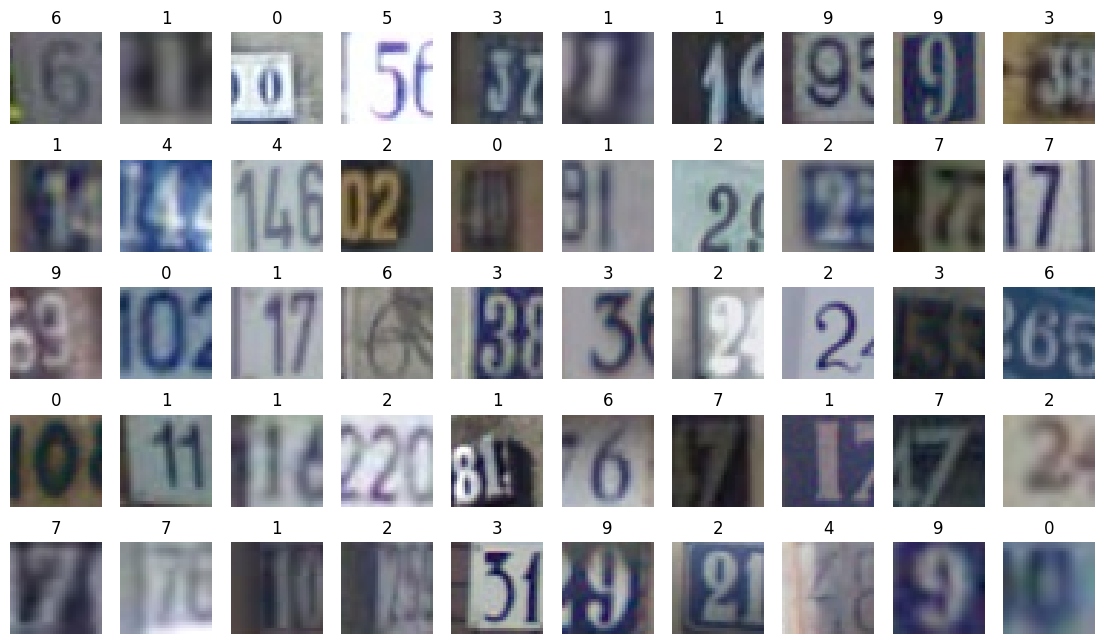

In [ ]:
img_chan, img_height, img_width = train_data[idx][0].shape #Channel, Height, Width

# Plots
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        image, label = train_data[index]
        image = image.permute((1, 2, 0)) #C,H,W -> H,W,C
        plt.imshow(image, cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(classes[label])
plt.show()

Since `train_data`, `val_data` and `test_data` are already PyTorch Datasets, we can use directly DataLoaders to load data from them.

In [ ]:
batch_size = 256
dataloader_training = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(val_data, batch_size=batch_size)
dataloader_test = DataLoader(test_data, batch_size=batch_size)

##Model Definition and Training

Let's create a simple CNN. The model will be composed of:
* One 2D Convolutional layer with kernel size $3\times3$ and $32$ output filters/features, that use ReLU activation function;
* a Max Pooling layer (2D) of size $2\times2$;
* a Flatten layer;
* a final Dense layer with 10 output neurons (one per class). We do not need to normalize or transform further the outputs, as the `CrossEntropyLoss` takes care of that. Another equivalent approach would be to add a `LogSoftmax` final layer that returns log-probabilities and then use the `NegativeLogLikelihoodLoss`., and with the `softmax` activation function to ensure that the sum of all the estimated class probabilities for each image is equal to 1.
Note that as `input_shape` attribute's value in the first layer report also the third dimension that represents the channel.

In [ ]:
class My_Convolutional_Network(nn.Module):
  def __init__(self, conv_filters=[], kernel_sizes=[], max_pool_sizes=[], act_fs=[], verbose=False):
    super().__init__()

    assert len(conv_filters) == len(kernel_sizes), "length of {conv_filters} and {kernel_sizes} must be same"
    assert len(conv_filters) == len(max_pool_sizes), "length of {conv_filters} and {max_pool_sizes} must be same"
    # max pool of [1, 1] corresponds to no max pool
    assert len(conv_filters) == len(act_fs), "length of {conv_filters} and {act_fs} must be same"

    self.conv_layers = nn.ModuleList()
    self.max_pools = nn.ModuleList()
    self.in_chan = img_chan
    self.in_height = img_height
    self.in_width = img_width
    self.output_dim = len(classes)#10
    self.verbose = verbose
    self.act_fs = act_fs

    height_dimension = self.in_height
    width_dimension = self.in_width

    for maxp1, maxp2 in max_pool_sizes: # as long as padding='same'
      height_dimension = height_dimension // maxp1
      width_dimension = width_dimension // maxp2

    self.inp_dim_to_linear = conv_filters[-1] * height_dimension * width_dimension

    for idx in range(len(conv_filters)):
      if idx == 0:
        # Conv2d(in_channels, out_channels, kernel_size, padding)
        self.conv_layers = self.conv_layers.append(Conv2d(self.in_chan, conv_filters[idx],
                                                          kernel_sizes[idx], padding='same'))
      else:
        self.conv_layers = self.conv_layers.append(Conv2d(conv_filters[idx-1], conv_filters[idx],
                                                          kernel_sizes[idx], padding='same'))

      self.max_pools = self.max_pools.append(MaxPool2d(max_pool_sizes[idx]))

    self.linear = Linear(self.inp_dim_to_linear, self.output_dim)

    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print(f"My model has {pytorch_total_params} trainable parameters.")

  def forward(self, x):

    for idx in range(len(self.conv_layers)):
      from_shape = x.shape[1:]
      active_conv_layer = self.conv_layers[idx]
      active_max_pool = self.max_pools[idx]
      active_act_fun = self.act_fs[idx]
      x = active_max_pool(active_act_fun(active_conv_layer(x)))
      to_shape = x.shape[1:]

      if self.verbose:
        print(f'From dimension [{from_shape}] to dimension [{to_shape}]')

    x = torch.flatten(x, start_dim=1) # if start_dim=1 missed, it also consider batch_size

    if self.verbose:
        print(f'From dimension [{to_shape}] to dimension [{x.shape[1:]}]')
        print(f'From dimension [{x.shape[1:]}] to dimension [{self.output_dim}]')

    return self.linear(x) # no need to use softmax because of the loss function

My model has 82826 trainable parameters.


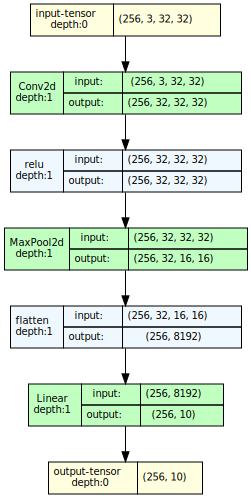

In [ ]:
conv_filters = [32]
kernel_sizes = [[3, 3]]
max_pool_sizes = [[2, 2]]
act_fs = [F.relu]

num_epochs = 20
lr = 1e-3
model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                 act_fs, False).to(device)

# Let's visualize the model
model_graph = draw_graph(model, input_size=(batch_size, 3, 32, 32), device=device)
model_graph.visual_graph

In [ ]:
# Here is another tool that gives a nice summary of our model!
summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-1                        --                        --
│    └─Conv2d: 2-1                       [256, 32, 32, 32]         896
├─ModuleList: 1-2                        --                        --
│    └─MaxPool2d: 2-2                    [256, 32, 16, 16]         --
├─Linear: 1-3                            [256, 10]                 81,930
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
Total mult-adds (M): 255.86
Input size (MB): 3.15
Forward/backward pass size (MB): 67.13
Params size (MB): 0.33
Estimated Total Size (MB): 70.61

## Q2: Parameters of a CNN [TO COMPLETE]

Explain in the cell below how the number of parameters for the Conv2D layers are determined. Perform the calculations to calculate the parameters of the Conv2D layer.

`%STARTEXT`

Answer: **[TO COMPLETE]**

```
conv_filters = [32] #number of filters
kernel_sizes = [[3, 3]] #filter size (3*3*3 - the last 3 represents the number of channels)
```
One bias term for each filter: bias = 32

$N_{parameters} = Kernel_{size} * ConvFilter_{size} + bias $

$3*3*3_{kernel} * 32_{ConvFilter} + 32_{bias} = 896$

`%ENDTEXT`

Now we can train the model.

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs, hparam_tuning=False):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  history1 = hl.History() # This is a simple tool for logging
  canvas1 = hl.Canvas() # This is a simple tool for plotting
  for epoch in range(epochs):

    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (img, label) in enumerate(dataloader_train):
      img, label = img.to(device), label.to(device)
      optimizer.zero_grad()
      logits = model(img)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      total_acc_train += (logits.argmax(1) == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)

    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (img, label) in enumerate(dataloader_val):
            img, label = img.to(device), label.to(device)
            logits = model(img)
            loss = criterion(logits, label)
            total_loss_val += loss
            total_acc_val += (logits.argmax(1) == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val)
    if epoch % 1 == 0:
      if not hparam_tuning:
        history1.log(epoch, train_loss=avg_loss_train, train_accuracy=accuracy_train,
                     val_loss=avg_loss_val, val_accuracy=accuracy_val)

        with canvas1:
          canvas1.draw_plot([history1["train_loss"], history1["val_loss"]])
          canvas1.draw_plot([history1["train_accuracy"], history1["val_accuracy"]])
      else:
        print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
        print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

def plot_learning_acc_and_loss(loss_tr, acc_tr, loss_val, acc_val):
    # Helper function to plot again accuracy and loss

    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.grid()
    plt.plot(range(len(acc_tr)), acc_tr, label='acc_training')
    plt.plot(range(len(acc_tr)), acc_val, label='acc_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.grid()
    plt.plot(range(len(acc_tr)), loss_tr, label='loss_training')
    plt.plot(range(len(acc_tr)), loss_val, label='loss_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

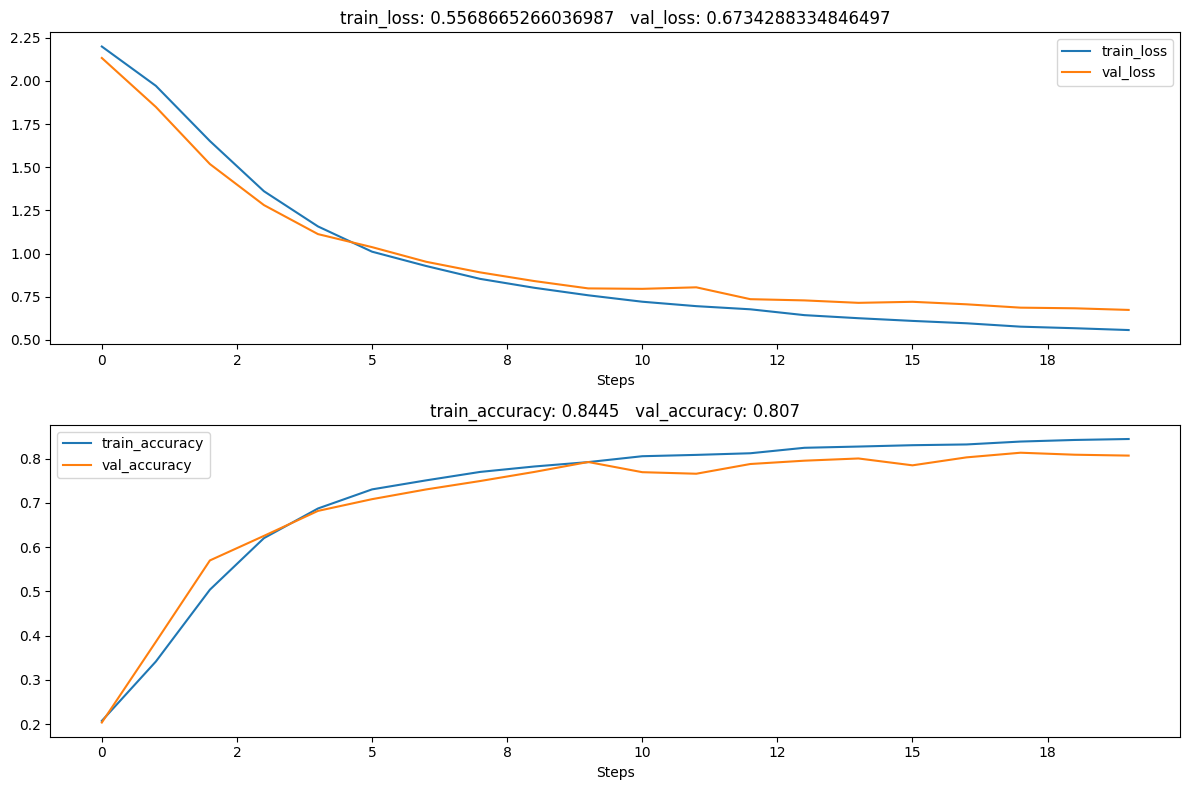

Training time in second: 84.2751226800001


In [ ]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

Finally, we test the model:

In [ ]:
def test(model, dataloader_test=dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (img, label) in enumerate(dataloader_test):
      img, label = img.to(device), label.to(device)
      logits = model(img)
      loss += criterion(logits, label)
      total_acc_test += (logits.argmax(1) == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")

In [ ]:
test(model)

Test Loss: 0.85715824 ---------- Test Accuracy: 77.7000%


Here we see that the test accuracy of our simple CNN should be about $77\%$.

## Visualize the Filters
Let's now visualize the filters learned in the first convolutional layer.

In [ ]:
# Get the weights
layer_names = []
weights = {}
for name, param in model.named_parameters():
    if param.requires_grad:
        layer_names.append(name)
        weights.setdefault(name, param.data)

conv_weights = weights['conv_layers.0.weight']
print(f"{conv_weights.shape=} <=> [out_dim, inp_dim, kernel_size[0], kernel_size[1]]")

conv_weights.shape=torch.Size([32, 3, 3, 3]) <=> [out_dim, inp_dim, kernel_size[0], kernel_size[1]]


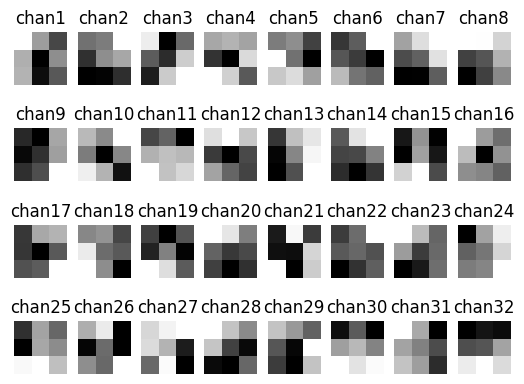

In [ ]:
conv_w0 = conv_weights[:, 0, :, :] # Pick one input dimension

# Rescale weights for visualization
conv_w0 -= torch.min(conv_w0)
conv_w0 /= torch.max(conv_w0)

for r in range(4):
    for c in range(8):
        n=r*8+c
        plt.subplot(4, 8, n+1)
        plt.imshow(conv_w0[n,:,:].cpu(), interpolation='none')
        plt.title(f'chan{n+1}')
        plt.axis('off')
        plt.gray()
plt.show()

They might be a bit hard to interpret, but it seems that the various filters have learned to detect different shapes and positions.

## Deep CNN


Let's consider a deeper model, more precisly in this exercise we consider a model composed of:
* One 2D convolutional layer with kernel size $3\times3$ and $32$ output filters/features, that use ReLu activation function;
* a Max Pooling layer (2D) of size $2\times2$;
* One 2D convolutional layer with kernel size $2\times2$ and $16$ output filters/features, that use ReLu activation function;
* a Max Pooling layer (2D) of size $2\times2$;
* a Flatten layer;
* a final Dense layer with $10$ output neurons (one per class), and with the `softmax` activation function.


My model has 13210 trainable parameters.


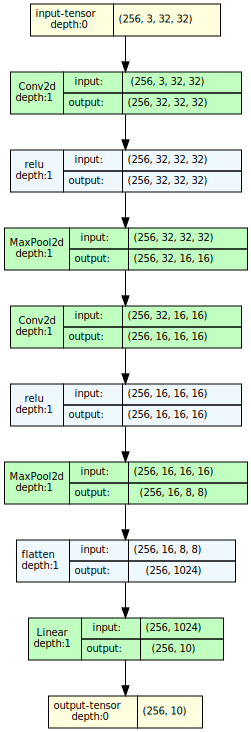

In [ ]:
conv_filters = [32, 16]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.relu, F.relu]

num_epochs = 20
lr = 1e-3
deep_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)

model_graph = draw_graph(deep_model, input_size=(batch_size, 3, 32, 32), device=device)
model_graph.visual_graph

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deep_model.parameters(), lr=lr)

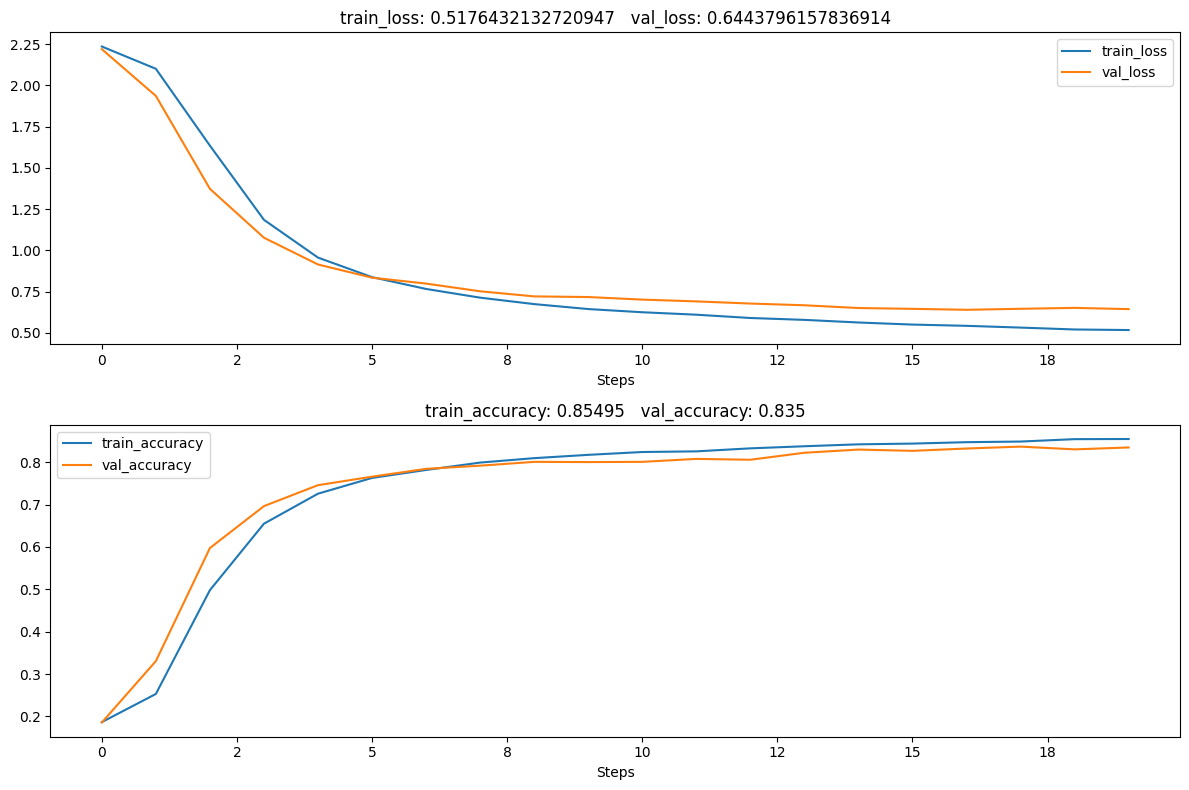

Training time in second: 78.14694831399993


In [ ]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(deep_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

In [ ]:
test(deep_model)

Test Loss: 0.78593862 ---------- Test Accuracy: 80.7500%


What?! By developing a deeper CNN (although it has fewer parameters), we just slighted increased the accuracy...it seems like we need to develop a better CNN.

# Exercise 3.2: A Better CNN

Let's develop a network that performs better than the very simple one above. This exercise aims to explore how much the various hyper-parameters influence the classification capability of the model.

**Q3 [TO COMPLETE]**: Your task is to modify some of the hyper-parameters of the previous exercise's network and compare the results. The requirements are as follows:
1. what your deemed to be your **best models** must show an improvement in the test set results (generalization) over the result of the baseline model used in the previous exercise;
2. in the code cell between `%STARTCODE` and `%ENDCODE` report the code of **only** your **best model**;
3. make sure that in the code cell between `%STARTCODE` and `%ENDCODE` you report also its result on the test set and plot the accuracy and the loss trends;
4. for each setup you tested, analyze and discuss the obtained results briefly in the last *text* cell at the bottom, motivating the choice of picking your **best model**.

Hint: Each reparameterization should change a different aspect in the network, while the rest of the parameters would stay the same. You can then jointly tune different hyperparamentes.
Example of parameters to tune are (we suggest to test at least one re-parametrization for each of these categories):

*   number of layers or neurons or filters dimension;
*   activation functions;
*   epochs;
*   max-pooling on/off on certain layers, or pool size;
*   learning rate;
*   ...



`%STARTCODE`

My model has 124554 trainable parameters.
epoch: 1 -> Accuracy: 29.37%, Loss: 2.01968455 ---------------- Val_Acc: 59.60%, Val_Loss: 1.27232134
epoch: 2 -> Accuracy: 74.19%, Loss: 0.86003888 ---------------- Val_Acc: 78.15%, Val_Loss: 0.73210174
epoch: 3 -> Accuracy: 82.25%, Loss: 0.60071570 ---------------- Val_Acc: 83.50%, Val_Loss: 0.58074206
epoch: 4 -> Accuracy: 85.36%, Loss: 0.50476992 ---------------- Val_Acc: 84.85%, Val_Loss: 0.53004283
epoch: 5 -> Accuracy: 86.91%, Loss: 0.45137605 ---------------- Val_Acc: 84.90%, Val_Loss: 0.51720029
epoch: 6 -> Accuracy: 88.04%, Loss: 0.40879336 ---------------- Val_Acc: 86.65%, Val_Loss: 0.46978986
epoch: 7 -> Accuracy: 89.22%, Loss: 0.37201080 ---------------- Val_Acc: 87.25%, Val_Loss: 0.45994934
epoch: 8 -> Accuracy: 89.87%, Loss: 0.34393355 ---------------- Val_Acc: 87.00%, Val_Loss: 0.46511140
epoch: 9 -> Accuracy: 91.14%, Loss: 0.31716469 ---------------- Val_Acc: 86.20%, Val_Loss: 0.47907621
epoch: 10 -> Accuracy: 91.44%, Loss: 0.2

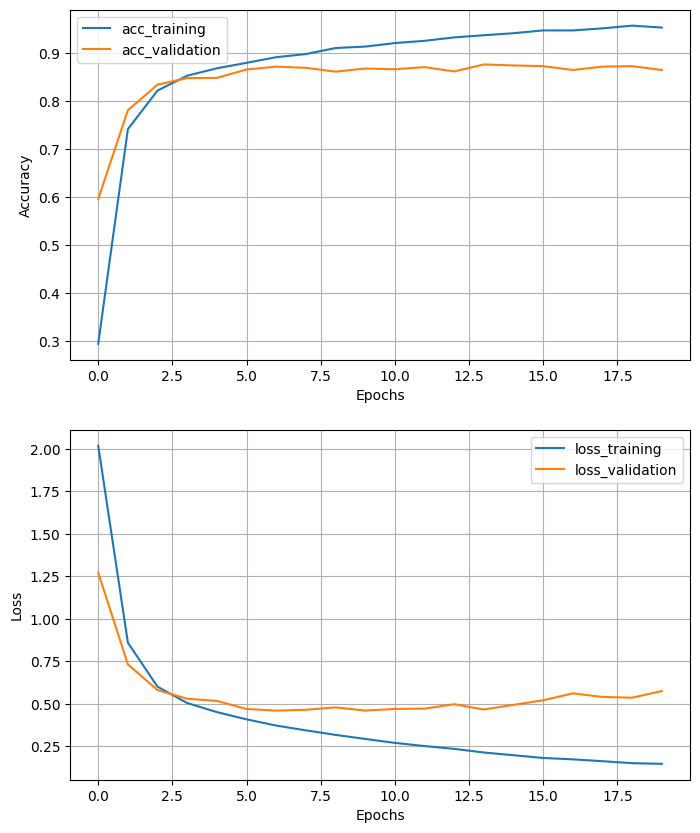

Test Loss: 0.81676662 ---------- Test Accuracy: 84.0500%
-------------------------------------------------------------------------------------


In [ ]:
# Feel free to edit the following (e.g. with for-loops or however you prefer)
n_epochs = 20 # TO COMPLETE
conv_filters = [128, 64, 64] # TO COMPLETE
kernel_sizes = [[3, 3], [3, 3], [3, 3]] # TO COMPLETE
max_pool_sizes = [[2, 2], [2, 2], [2, 2]] # TO COMPLETE
act_fs = [F.elu, F.elu, F.elu] # TO COMPLETE
lr = 1e-3 # TO COMPLETE

model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes, act_fs, False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

start = timer()
# Notice hparam_tuning=True
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, n_epochs, hparam_tuning=True)
end = timer()

print(f"Training time in second: {(end - start)}")
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)
test(model)
print("-"*85)

## Q3: Discuss your results [TO COMPLETE]

In the discussion, you need to clearly motivate your choice of hyperparameters, what work and what did not work, and how you picked your best model. Most of the HW grade depends on this, so to support you we provide a answer guideline.

`%STARTEXT`

The best model that I found is... **[TO COMPLETE]**

```
n_epochs = 20
conv_filters = [128, 64, 64]
kernel_sizes = [[3, 3], [3, 3], [3, 3]]
max_pool_sizes = [[2, 2], [2, 2], [2, 2]]
act_fs = [F.elu, F.elu, F.elu]
lr = 1e-3
```

The achieved accuracy in the test set is 84.0500% **[TO COMPLETE]**

Discussion: **[TO COMPLETE]**

I increase the number of filters in each layer and the number of layers to improve the accuracy in the training set. However, I kept the learning rate and the number of epochs low to mitigate the risk of overfitting, allowing the model to generalize better.

Besides, I tested also other models:
* **[TO COMPLETE]**
* ..

Model 0
```
num_epochs = 20
conv_filters = [32, 16]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.relu, F.relu]
lr = 1e-3
```
$Acc_{train} = 84.58 \%$ and $Acc_{test} = 79.7000 \ $

---

From this model I adjusted various parameters and I observed their effects on my model.

Model 1 - increase the number of filters in each layer
```
n_epochs = 20
conv_filters = [64, 32]
kernel_sizes = [[3, 3], [3, 3]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.relu, F.relu]
lr = 1e-3
```
$Acc_{train} = 87.44 \%$ and $Acc_{test} = 81.9500 \%$

---

Model 2 - add one layer
```
n_epochs = 20
conv_filters = [64, 64, 32]
kernel_sizes = [[3, 3], [3, 3], [3, 3]]
max_pool_sizes = [[2, 2], [2, 2], [2, 2]]
act_fs = [F.relu, F.relu, F.relu]
lr = 1e-3
```
$Acc_{train} = 88.44 \%$ and $Acc_{test} = 83.7500 \%$

---

Model 3 - reduce the learning rate
```
n_epochs = 20
conv_filters = [64, 64, 32]
kernel_sizes = [[3, 3], [3, 3], [3, 3]]
max_pool_sizes = [[2, 2], [2, 2], [2, 2]]
act_fs = [F.relu, F.relu, F.relu]
lr = 1e-4
```
$Acc_{train} = 75.23 \%$ and $Acc_{test} = 76.2500 \%$

---

Model 4 - increase the number of epochs
```
n_epochs = 30
conv_filters = [64, 64, 32]
kernel_sizes = [[3, 3], [3, 3], [3, 3]]
max_pool_sizes = [[2, 2], [2, 2], [2, 2]]
act_fs = [F.relu, F.relu, F.relu]
lr = 1e-3
```
$Acc_{train} = 91.16 \%$ and $Acc_{test} = 82.1000 \%$

---

Model 5 - improve the number of filters for layers
```
n_epochs = 20
conv_filters = [128, 64, 64]
kernel_sizes = [[3, 3], [3, 3], [3, 3]]
max_pool_sizes = [[2, 2], [2, 2], [2, 2]]
act_fs = [F.relu, F.relu, F.relu]
lr = 1e-3
```
$Acc_{train} = 90.77 \%$ and $Acc_{test} = 83.800 \%$

---

Model 6 - change activation function
```
n_epochs = 20
conv_filters = [128, 64, 64]
kernel_sizes = [[3, 3], [3, 3], [3, 3]]
max_pool_sizes = [[2, 2], [2, 2], [2, 2]]
act_fs = [F.elu, F.elu, F.elu]
lr = 1e-3
```
$Acc_{train} = 95.41 \%$ and $Acc_{test} = 84.3000 \%$

---

Discussion: **[TO COMPLETE]**

Starting from model 0, I modified several parameters:
* Model 1: I increased the number of filters in each layer, improving my model.
* Model 2: I added one layer, improving my model.
* Model 3: I reduced the learning rate, worsening my model. The accuracy in both training and testing became worse so I decided not to use this learning rate update.
* Model 4: I increased the number of epochs. The model is more accurate in training but has worse accuracy in testing, so my model is overfitting. I thus decided not to use this update.
* Model 5: I increased the number of filters in each layer, improving my model.
* Model 6: I changed the activation function from relu to elu getting better results. So this is my final model.

`%ENDTEXT`

## Q4: Data Augmentation [TO COMPLETE]

Besides hyperparameter tuning, another approach to improve performances is _Data Augmentation_, i.e. we exploit our available data to get new samples with some heuristrics and tricks, with the aim to improve generalization. In practice, you can have a look [here](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html) for some examples, and it has been shown that a valid technique for SVHN is _inverting_ the colors of the RGB images (since the label is the number at the center of the image, croping, flipping and rotating might change the data completely in a way that the label does not anymore correspond to the number at the center of the image).

**[TO COMPLETE]**
Reload and augment the SVHN dataset, and along your `MinMaxScaler`, use the `invert` function from `torchvision.transforms.functional` to invert the pixels of a random $1/3$ of the (smaller) training/validation set.
Retrain your **best model** on this new dataset and check whether it improves generalization performances.

`%STARTCODE`

In [ ]:
####################### DATA AUGMENTATION ###############################
from torchvision.transforms import RandomInvert

# In torch, transformations have to be composed
# Concatenate MinMaxScaler, and a Transformation that inverts randomly 1/3 of the samples
# ...
data_augmentation = transforms.Compose([Lambda(MinMaxScaler), RandomInvert(1/3)]) # TO COMPLETE

'''
NEW DATA LOADING
Note that the previous function must be passed to transforms.Lambda().
'''
new_dataset = SVHN(root='data/', download=True, split="train", transform=data_augmentation) # 50000 samples

train_size = 30000
val_size = 2000
rest_size = len(new_dataset) - (train_size + val_size)
new_train_data, new_val_data, _ = random_split(new_dataset, [train_size, val_size, rest_size])

# We do not augment the test data!
testing_data = SVHN(root='data/', download=True, split="test", transform=Lambda(MinMaxScaler)) # 10000 samples
test_size = 2000
rest_size = len(testing_data) - test_size
new_test_data, _ = random_split(testing_data, [test_size, rest_size])


print(f"Training samples = {len(new_train_data)} \nValidation samples = {len(new_val_data)} \nTest samples = {len(new_test_data)}")

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Training samples = 30000 
Validation samples = 2000 
Test samples = 2000


In [ ]:
batch_size = 256
aug_dataloader_training = DataLoader(new_train_data, batch_size=batch_size, shuffle=True)
aug_dataloader_validation = DataLoader(new_val_data, batch_size=batch_size)
aug_dataloader_test = DataLoader(new_test_data, batch_size=batch_size)

My model has 124554 trainable parameters.


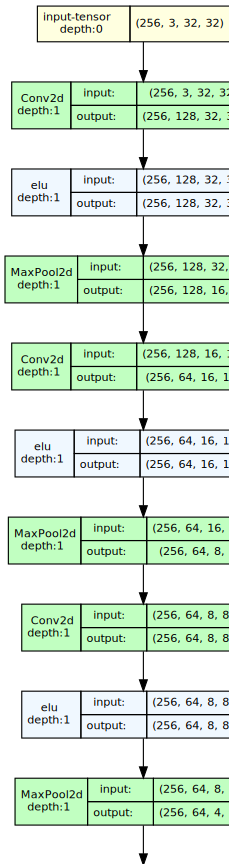

In [ ]:
# Insert your best model
conv_filters = [128, 64, 64] # TO COMPLETE
kernel_sizes = [[3, 3], [3, 3], [3, 3]] # TO COMPLETE
max_pool_sizes = [[2, 2], [2, 2], [2, 2]] # TO COMPLETE
act_fs = [F.elu, F.elu, F.elu] # TO COMPLETE
n_epochs = 20 # TO COMPLETE
lr = 1e-3 # TO COMPLETE

aug_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                 act_fs, False).to(device)

model_graph = draw_graph(aug_model, input_size=(batch_size, 3, 32, 32), device=device)
model_graph.visual_graph

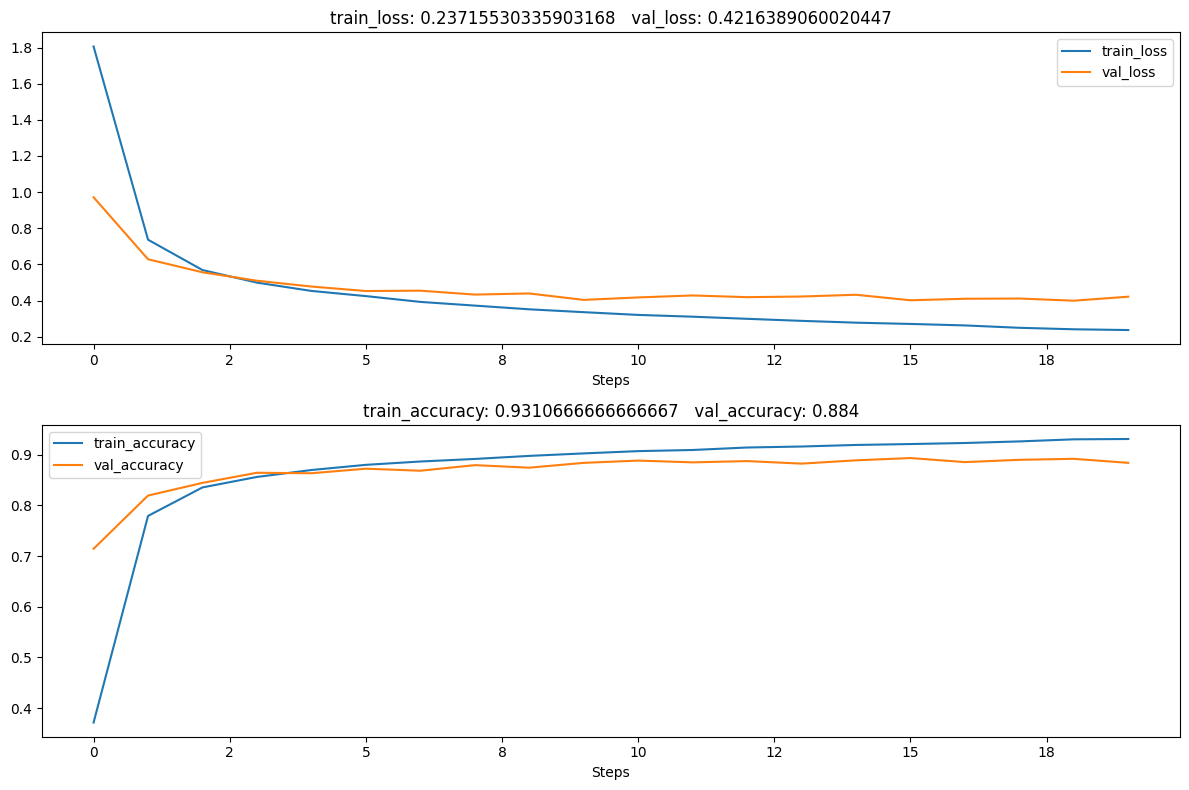

In [ ]:
optimizer = torch.optim.Adam(aug_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(aug_model, optimizer, aug_dataloader_training, aug_dataloader_validation, num_epochs, False)
end = timer()

In [ ]:
print("Results of my best CNN with Data Augmentation:")
test(aug_model, aug_dataloader_test)

Results of my best CNN with Data Augmentation:
Test Loss: 0.42672670 ---------- Test Accuracy: 89.0500%


`%ENDCODE`

# Transfer Learning with ResNet18 + ImageNet

Let's now experiment with transfer learning. We will now load the model structure and weights of a small [ResNet](https://en.wikipedia.org/wiki/Residual_neural_network) (which is still pretty big!), pretrained on the ImageNet dataset. We will then add a fully connected layer at the end of the network and fine-tune it on the SVHM dataset. In this way, we can leverage the knowledge already present in the pre-trained weight and transfer it on our task!

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

In [ ]:
RESNET18 = resnet18(pretrained=True)
#model_graph = draw_graph(RESNET18, input_size=(1, 3, 32, 32), device=device, expand_nested=True)
#model_graph.visual_graph
summary(RESNET18, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [256, 1000]               --
├─Conv2d: 1-1                            [256, 64, 16, 16]         9,408
├─BatchNorm2d: 1-2                       [256, 64, 16, 16]         128
├─ReLU: 1-3                              [256, 64, 16, 16]         --
├─MaxPool2d: 1-4                         [256, 64, 8, 8]           --
├─Sequential: 1-5                        [256, 64, 8, 8]           --
│    └─BasicBlock: 2-1                   [256, 64, 8, 8]           --
│    │    └─Conv2d: 3-1                  [256, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-2             [256, 64, 8, 8]           128
│    │    └─ReLU: 3-3                    [256, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [256, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-5             [256, 64, 8, 8]           128
│    │    └─ReLU: 3-6                    [256, 64, 8, 8]           --
│

The ResNet has a final fully connected layer that generates 1000 logits corresponding to the classes in the ImageNet dataset. We will re-define it and make it map the features learned in the previous layer to the 10 classes of the SVHM datset.

In [ ]:
linear_layer_input = RESNET18.fc.in_features
linear_layer_output = RESNET18.fc.out_features
print(f"Last layer: {linear_layer_input} -> {linear_layer_output}")

Last layer: 512 -> 1000


In [ ]:
# Replace  the last layer
RESNET18.fc = Linear(linear_layer_input, 10)

In [ ]:
linear_layer_input = RESNET18.fc.in_features
linear_layer_output = RESNET18.fc.out_features
print(f"Last layer: {linear_layer_input} -> {linear_layer_output}")

Last layer: 512 -> 10


Finally, we "freeze" the other weights in the network so that only the ones in the last layer are trainable.

In [ ]:
for name, param in RESNET18.named_parameters():
    if name == 'fc.weight' or name == 'fc.bias':
      param.requires_grad = True
    else:
      param.requires_grad = False

In [ ]:
RESNET18 = RESNET18.to(device) # Let's now load it to GPU

Let's consider a smaller subset in order to speed-up the fine-tuning process:

In [ ]:
train_idxs = list(range(0, len(train_data), 5))  # ~ 4000 Tr
val_idxs = list(range(1, len(val_data), 5))  # ~ 400 Val
test_idxs = list(range(1, len(test_data), 5))  # ~ 400 Ts

train_data_sub = torch.utils.data.Subset(train_data, train_idxs)
val_data_sub = torch.utils.data.Subset(val_data, val_idxs)
test_data_sub = torch.utils.data.Subset(test_data, test_idxs)

In [ ]:
len(train_idxs), len(val_idxs), len(test_idxs)

(4000, 400, 400)

In order to apply custom preprocessing steps that are expected by the pretrained model, we will define a small wrapper around our dataset.

In [ ]:
weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()

class RESDatasetWrapper(Dataset):
  def __init__(self, dataset):
    self.dataset = dataset
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    image, label = self.dataset[idx]
    image = preprocess(image)
    label = torch.tensor(label, dtype=torch.long)
    return image.to(device), label.to(device)

In [ ]:
RES_train_dataset = RESDatasetWrapper(train_data_sub)
RES_val_dataset = RESDatasetWrapper(val_data_sub)
RES_test_dataset = RESDatasetWrapper(test_data_sub)

batch_size=256

RES_dataloader_training = DataLoader(RES_train_dataset, batch_size=batch_size, shuffle=True)
RES_dataloader_validation = DataLoader(RES_val_dataset, batch_size=batch_size)
RES_dataloader_test = DataLoader(RES_test_dataset, batch_size=batch_size)

In [ ]:
num_epochs = 20
lr = 1e-3

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RESNET18.parameters(), lr=lr)

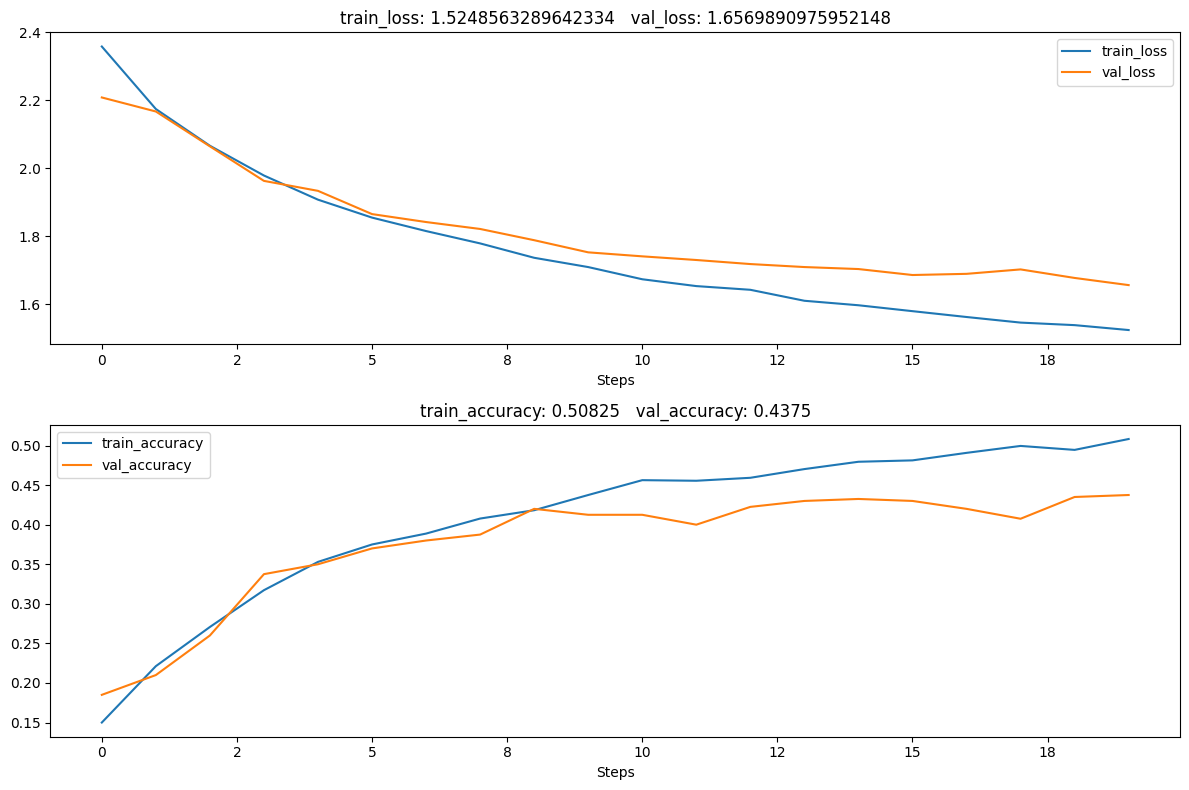

Training time in second: 203.36214459200073


In [ ]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(RESNET18, optimizer,
                                                           RES_dataloader_training,
                                                           RES_dataloader_validation,
                                                           epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

In [ ]:
test(RESNET18, dataloader_test=RES_dataloader_test)

Test Loss: 1.72789180 ---------- Test Accuracy: 40.0000%


Notice how we got this result by leveraging a model freely available on the internet and trained on another dataset. That's the power of transfer learning!